<a href="https://colab.research.google.com/github/algcurves/AJM/blob/master/2_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Nearest Neighbor (kNN) classifier

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples

In this exercise you will implement these steps and understand the basic Image Classification pipeline, and gain proficiency in writing efficient code.

In [103]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf # install tensorflow if you work on your own computer instead of colab

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# Load the raw MNIST data.

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


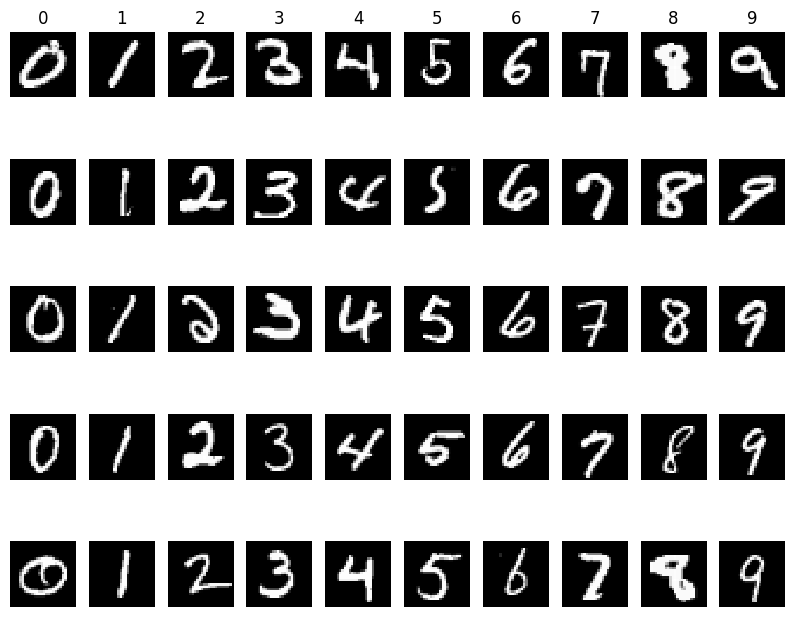

In [105]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = range(10)
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [106]:
# Subsample the data for more efficient code execution in this exercise
num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 100
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float32')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float32')
print(X_train.shape, X_test.shape)

(500, 784) (100, 784)


# What you need to implement is here

In [121]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance (i.e., Euclidean distance) """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def compute_distances(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance (L2 distance) between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You can implement this function using only basic array operations.    #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #                                                                       #
        # Or you can use functions from numpy such as np.linalg.norm()          #
        #                                                                       #
        #########################################################################
        ## 20 points ##
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        #X = X[:, np.newaxis, :]
        #for i in range(num_test):
        #  for j in range(num_train):
        #     dists[i][j]=np.linalg.norm(X[i]- self[j], axis=-1)
        #dists=np.linalg.norm(X- self, ord==2)


        dot_product = np.dot(X, self)
        X_sum_squares = np.sum(X**2, axis=1, keepdims=True)
        self_sum_squares = np.sum(self**2, axis=1)
        squared_dist = X_sum_squares - 2*dot_product + self_sum_squares
        dists = np.sqrt(squared_dist)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            ## 10 points ##
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            closest_y=np.argsort(dists[i])

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            ## 10 points ##
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            y_pred=np.argmax(closest_y)


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

    def predict(self, X, k=1):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distances(X)

        return self.predict_labels(dists, k=k)

In [102]:
def compute_l2_distance(test_points, training_points):
    # Calculate the dot product between test points and training points
    dot_product = np.dot(test_points, training_points.T)

    # Sum of squares of test points and training points
    test_sum_squares = np.sum(test_points**2, axis=1, keepdims=True)
    training_sum_squares = np.sum(training_points**2, axis=1)

    # Calculate the squared L2 distance
    squared_dist = test_sum_squares - 2 * dot_product + training_sum_squares

    # Take the square root to get the L2 distance
    dists = np.sqrt(squared_dist)

    return dists

# Example usage:
X = np.array([[1, 2], [3, 4], [5, 6]])
self = np.array([[2, 2], [4, 4]])

dists = compute_l2_distance(X, self)
print(dists)



[[1.         3.60555128]
 [2.23606798 1.        ]
 [5.         2.23606798]]


In [122]:
# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

In [123]:
# implement compute_distances

# Test your implementation:
dists = classifier.compute_distances(X_test)
print(dists.shape)
# We can visualize the distance matrix: each row is a single test example and its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

AttributeError: ignored

In [119]:
# Now implement the function predict_labels and run the code below:

# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print(f'Got {num_correct} / {num_test} correct => accuracy: {accuracy*100:.0f}%')

Got 8 / 100 correct => accuracy: 8%


You should expect to see `85%` accuracy. Now lets try out a larger `k`, say `k = 2`:

In [120]:
y_test_pred = classifier.predict_labels(dists, k=2)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print(f'Got {num_correct} / {num_test} correct => accuracy: {accuracy*100:.0f}%')

Got 8 / 100 correct => accuracy: 8%


You should expect to see a slightly worse performance than with `k = 1` for this small dataset. You can try other k and calculate the prediction accuracy.